# CSCI 6364 Final Project - William Zabet

## A Machine Learning Approach on Analyzing Crime Data in Washington, D.C.

In [2]:
# Importing Required Libraries for the project. 

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from scipy.stats import pearsonr
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from numpy import random, float, array
import numpy as np
import seaborn as sns

import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy.stats import pearsonr
import numpy as np
from pandas.io.json import json_normalize #special package in pandas
import matplotlib.pyplot as plt
%matplotlib inline
import os
# conda install -c conda-forge plotnine
from plotnine import *
from plotnine.data import *
import statsmodels.api as sm

### Initial Preprocessing of data

In [3]:
def compiler(start_year, end_year):
    
    crime = pd.DataFrame()
    
    crime.drop(crime.index, inplace=True)
        
    for year in range(start_year, end_year + 1):
        
        dc_crime = pd.read_csv("Crime_Incidents_in_{}.csv".format(year))
        
        compilerList = [('SHIFT','DAY'), ('SHIFT','EVENING'), ('SHIFT','MIDNIGHT'),
                        ('OFFENSE','THEFT/OTHER'), ('OFFENSE','BURGLARY'), ('OFFENSE','ROBBERY'),
                        ('OFFENSE','ASSAULT W/DANGEROUS WEAPON'),
                        ('OFFENSE','MOTOR VEHICLE THEFT'), ('METHOD','KNIFE'), ('METHOD','GUN')]
                
        for i in compilerList:
            
            crime_inter0 = pd.DataFrame()
            crime_inter0.drop(crime_inter0.index, inplace=True)
            
            globals()['%s' % i[1].replace(" ", "_")] = dc_crime.loc[dc_crime[i[0]] == i[1]]
            globals()['%s' % i[1].replace(" ", "_")] = globals()['%s' % i[1].replace(" ", "_")][[i[0], 'WARD']].groupby(['WARD']).agg('count')
            globals()['%s' % i[1].replace(" ", "_")] = globals()['%s' % i[1].replace(" ", "_")].reset_index()
            globals()['%s' % i[1].replace(" ", "_")] = globals()['%s' % i[1].replace(" ", "_")].astype(int)
            globals()['%s' % i[1].replace(" ", "_")]["YEAR"] = year
            globals()['%s' % i[1].replace(" ", "_")] = globals()['%s' % i[1].replace(" ", "_")][['YEAR', 'WARD', i[0]]]
            globals()['%s' % i[1].replace(" ", "_")].columns = ['YEAR', 'WARD', 'Crime Incidents (' + i[1].replace(" ", "_") +')']
            globals()['%s' % i[1].replace(" ", "_")] = globals()['%s' % i[1].replace(" ", "_")].astype(int)
            
        first = True
        
        crime_inter = pd.DataFrame()
        crime_inter.drop(crime_inter.index, inplace=True)
        
        for i in compilerList:
            if first == True:
                crime_inter = globals()['%s' % i[1].replace(" ", "_")]
                first = False
            else:
                crime_inter = pd.merge(crime_inter, globals()['%s' % i[1].replace(" ", "_")], on=["YEAR", "WARD"])
        
        crime = crime.append(crime_inter)
        
    return crime.reset_index()

In [4]:
def compiler0(start_year, end_year):

    crime = pd.DataFrame()
    
    crime.drop(crime.index, inplace=True)
        
    for year in range(start_year, end_year + 1):
        
        dc_crime = pd.read_csv("Crime_Incidents_in_{}.csv".format(year))
        crime = crime.append(dc_crime)
        
    crime = crime[['WARD', 'REPORT_DAT']].drop_duplicates(keep=False)
    crime = crime.groupby(['WARD']).agg('count').reset_index()
    crime.columns = ['WARD', 'Total Crime ('+str(start_year)+'-'+str(end_year)+')']
    
    wards = pd.read_csv("Ward_from_2012.csv") #Loading general census information for DC 
    wards = wards.rename(columns={"POP_2011_2015": "TOTAL_POP"}).sort_values(by=["WARD"])
    wards['POP_DENSITY'] = + wards['TOTAL_POP'] / wards['AREASQMI']
    
    population = wards.iloc[[0,1,2,3,4,5,6,7], [1,10,15, 82, 16,17,18,19,20,21,22,23,24,25]]

    age = wards.iloc[[0,1,2,3,4,5,6,7], [1,26,27,28,29,30,31,32,33,34,64,35,36,37,38,39,40,41,42,43,44,45,46,47,48]]

    household = wards.iloc[[0,1,2,3,4,5,6,7], [1,50,51,52,53,54,68,69]]

    education = wards.iloc[[0,1,2,3,4,5,6,7], [1,65,66,74,75,76,77,78]]

    economic = wards.iloc[[0,1,2,3,4,5,6,7], [1,49,55,56,57,58,59,60,62,72,73,63,70,71]]

    businesses = pd.read_csv("Certified_Business_Enterprise.csv")
    businesses = businesses[['WARD', 'OBJECTID', 'DATEESTABLISHED']]
    businesses = businesses.loc[businesses['DATEESTABLISHED'].str.contains(str(np.arange(1850, end_year+1)), 
                                                                           na = False)]
    businesses = businesses[['OBJECTID', 'WARD']].groupby(['WARD']).agg('count')
    businesses.columns = ['Business Establishments']
    businesses = businesses.reset_index()
    businesses = businesses.astype(int)
    
    crime = pd.merge(crime, population, on="WARD")
    crime = pd.merge(crime, age, on="WARD")
    crime = pd.merge(crime, household, on="WARD")
    crime = pd.merge(crime, education, on="WARD")
    crime = pd.merge(crime, economic, on="WARD")
    crime = pd.merge(crime, businesses, on="WARD")
    del crime['POP_25_PLUS']
    
        
    return crime

### Using K - Nearest Neighbor to construct a Ward Classifier

In [503]:
def knnWard(train_start_year, train_end_year, test_start_year, test_end_year, scale = True):
    
    if scale == True:
        scale = True
    else:
        scale = False
        
    train = compiler(train_start_year, train_end_year)
    test = compiler(test_start_year, test_end_year).iloc[:,3:]
    
    X = train.iloc[:,3:].values
    y = train.iloc[:,2].values
    
    def best_k_accuracies():
        
        test_random_state = [25, 42, 100]
        for vals in np.arange(1,10):
            test_random_state.append(vals)

        kList = []
        
        for rs in test_random_state:
            
            X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=rs, stratify=y)
            
            k = 0
            score = 0
            kVals = np.arange(3,10)
            kDict = {}
            kList0 = []
          
            for x in kVals:
                model = KNeighborsClassifier(n_neighbors=x)
                model.fit(X_train,y_train)
                i_score = model.score(X_test, y_test)
                kDict[x] = i_score
            
            for key, value in kDict.items():
                if value == max(kDict.values()):
                    kList0.append((key, value, rs, scale))
            
            kList.append(kList0)
            
        return kList
        
    kList = best_k_accuracies()
    bestScores = ""
                    
    master_list = []
    for x in kList:
        for y in x:
            if y[1] != 1:
                master_list.append((y[0], y[1], y[2], y[3]))

    def predictions():  
        scores = []
        
        for x in master_list:
        
            train = compiler(train_start_year, train_end_year)
            test = compiler(test_start_year, test_end_year).iloc[:,3:]
    
            X = train.iloc[:,3:].values
            y = train.iloc[:,2].values  
            
            X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=x[2], stratify=y)
                
            if scale == True:
                sc = StandardScaler()
                X_train = sc.fit_transform(X_train)
                X_test = sc.transform(X_test)
    
            model = KNeighborsClassifier(n_neighbors=x[0])
            model.fit(X_train,y_train)

            i1 = 0
            i2 = 1
            ward = 1
            num_correct = 0
            total = 0
                
            for i in range(1,len(test)+1):
                prediction = model.predict(test[i1:i2].values)              
                if prediction == ward:
                    num_correct +=1              
                i1 = i1 + 1
                i2 = i2 + 1                        
                if ward == 8:
                    ward = 1
                else:
                    ward +=1
                total +=1
            
            scores.append((x[0], x[1], x[2], x[3], num_correct/total))
            
        return scores
    
    def bestResults():
        
        scores = predictions()
        scores0 = []
        scores1 = []
        
        for i in scores:
            scores0.append(i[4])
        for i in scores:
            if i[4] == max(scores0):
                scores1.append((i[0], i[1], i[2], i[3], i[4]))
        return scores1
    
    def output():
        scores1 = bestResults()
        count = 0
        for x in scores1:
            
            if count == 5:
                continue
            
            train = compiler(train_start_year, train_end_year)
            test = compiler(test_start_year, test_end_year).iloc[:,3:]
    
            X = train.iloc[:,3:].values
            y = train.iloc[:,2].values  
            
            X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=x[2], stratify=y)
                
            if scale == True:
                sc = StandardScaler()
                X_train = sc.fit_transform(X_train)
                X_test = sc.transform(X_test)
                
            print(" K=", x[0], "With", x[1]*100, "% Accuracy,\n Random State of", x[2],
                  "\n Accuracy on Data Set:", x[4]*100 , "\n Standardized Scaling:", scale)
            print("Actual Ward ", "| Predicted Ward", "| CORRECT?")
    
            model = KNeighborsClassifier(n_neighbors=x[0])
            model.fit(X_train,y_train)

            i1 = 0
            i2 = 1
            ward = 1
            
            for i in range(1,len(test)+1):
                prediction = model.predict(test[i1:i2].values)              
                if prediction == ward:
                    print(ward,"           |     ", prediction, "      | YES")
                else:
                    print(ward,"           |     ", prediction, "      | NO")             
                i1 = i1 + 1
                i2 = i2 + 1                        
                if ward == 8:
                    ward = 1
                else:
                    ward +=1
            count+=1

    output()

In [504]:
knnWard(2012, 2016, 2017, 2021, False)

 K= 3 With 90.0 % Accuracy,
 Random State of 3 
 Accuracy on Data Set: 60.0 
 Standardized Scaling: False
Actual Ward  | Predicted Ward | CORRECT?
1            |      [1]       | YES
2            |      [2]       | YES
3            |      [3]       | YES
4            |      [4]       | YES
5            |      [5]       | YES
6            |      [6]       | YES
7            |      [7]       | YES
8            |      [4]       | NO
1            |      [1]       | YES
2            |      [2]       | YES
3            |      [3]       | YES
4            |      [4]       | YES
5            |      [5]       | YES
6            |      [6]       | YES
7            |      [7]       | YES
8            |      [4]       | NO
1            |      [1]       | YES
2            |      [2]       | YES
3            |      [3]       | YES
4            |      [4]       | YES
5            |      [5]       | YES
6            |      [6]       | YES
7            |      [7]       | YES
8            |      [4]    

In [505]:
knnWard(2012, 2016, 2017, 2021, True)

 K= 3 With 90.0 % Accuracy,
 Random State of 42 
 Accuracy on Data Set: 12.5 
 Standardized Scaling: True
Actual Ward  | Predicted Ward | CORRECT?
1            |      [2]       | NO
2            |      [2]       | YES
3            |      [2]       | NO
4            |      [2]       | NO
5            |      [2]       | NO
6            |      [2]       | NO
7            |      [2]       | NO
8            |      [2]       | NO
1            |      [2]       | NO
2            |      [2]       | YES
3            |      [2]       | NO
4            |      [2]       | NO
5            |      [2]       | NO
6            |      [2]       | NO
7            |      [2]       | NO
8            |      [2]       | NO
1            |      [2]       | NO
2            |      [2]       | YES
3            |      [2]       | NO
4            |      [2]       | NO
5            |      [2]       | NO
6            |      [2]       | NO
7            |      [2]       | NO
8            |      [2]       | NO
1         

### Using Linear Regression to construct: 
#### 1. A Ward Classifier
#### 2. Analyze Potential Relationships between Crime Statistics and Census Data by Ward

In [784]:
def ward_lm0(randomState):
    df = compiler0(2011, 2015)
    
    X = df.iloc[:, 2:]
    y = df.iloc[:, 1:2]
    
    data = pd.DataFrame()
    data.drop(data.index, inplace=True)
    
    mseList = []
    mseList0 = []
        
    test_random_state = [25, 42, 100]
    for vals in np.arange(1,10):
        test_random_state.append(vals)
    
    for rs in test_random_state:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs)
        
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        
        predictions = lm.predict(X_test)
        
        mse = format(metrics.mean_squared_error(y_test, predictions))        
        
        mseList.append(rs)
        mseList0.append(int("{:.0f}".format(float(mse))))
                
        if rs == randomState:
            
            mse0 = mse
            
            data0 = pd.DataFrame()
            data0.drop(data0.index, inplace=True)
            data1 = pd.DataFrame()
            data1.drop(data1.index, inplace=True)
            data2 = pd.DataFrame()
            data2.drop(data2.index, inplace=True)
            data3 = pd.DataFrame()
            data3.drop(data3.index, inplace=True)
            data4 = pd.DataFrame()
            data4.drop(data4.index, inplace=True)
            data5 = pd.DataFrame()
            data5.drop(data5.index, inplace=True)
            data6 = pd.DataFrame()
            data6.drop(data6.index, inplace=True)
            data7 = pd.DataFrame()
            data7.drop(data7.index, inplace=True)
            
            data0["Variables"] = X.columns[0:8]
            data0["Coefficients"] = lm.coef_[0][0:8]
            data0['temp'] = np.arange(0,8)
            data = data0
            
            data1["Variables"] = X.columns[8:16]
            data1["Coefficients"] = lm.coef_[0][8:16]
            data1['temp'] = np.arange(0,8)
            data = pd.merge(data, data1, on = 'temp')
 
            data2["Variables"] = X.columns[16:24]
            data2["Coefficients"] = lm.coef_[0][16:24]
            data2['temp'] = np.arange(0,8)
            data = pd.merge(data, data2, on = 'temp')        
            
            data3["Variables"] = X.columns[24:32]
            data3["Coefficients"] = lm.coef_[0][24:32]
            data3['temp'] = np.arange(0,8)
            data = pd.merge(data, data3, on = 'temp')  

            data4["Variables"] = X.columns[32:40]
            data4["Coefficients"] = lm.coef_[0][32:40]
            data4['temp'] = np.arange(0,8)
            data = pd.merge(data, data4, on = 'temp')

            data5["Variables"] = X.columns[40:48]
            data5["Coefficients"] = lm.coef_[0][40:48]
            data5['temp'] = np.arange(0,8)
            data = pd.merge(data, data5, on = 'temp')  

            data6["Variables"] = X.columns[48:56]
            data6["Coefficients"] = lm.coef_[0][48:56]
            data6['temp'] = np.arange(0,8)
            data = pd.merge(data, data6, on = 'temp')
            
            data7["Variables"] = X.columns[56:64]
            data7["Coefficients"] = lm.coef_[0][56:64]
            data7['temp'] = np.arange(0,8)
            data = pd.merge(data, data7, on = 'temp')            
            data = data.drop('temp', axis=1)
    
    if randomState != None:
        print("Showing Data Frame of MSE at Random State ("+str(randomState)+") =",mse0)
    else:
        mseDict = {'Random_State': pd.Series(mseList),
                   'MSE' : pd.Series(mseList0)}
        data = pd.DataFrame(mseDict)
        print(data['MSE'].describe(include='all'))
        
    return data

In [786]:
ward_lm0(None)

count    1.200000e+01
mean     9.259577e+07
std      4.488510e+07
min      1.902741e+06
25%      6.970275e+07
50%      1.041954e+08
75%      1.278114e+08
max      1.506988e+08
Name: MSE, dtype: float64


,Random_State,MSE
0,25,92038545
1,42,72806791
2,100,104195355
3,1,129173480
4,2,104195355
5,3,25331067
6,4,1902741
7,5,129173480
8,6,60390608
9,7,127357348


In [793]:
ward_lm0(25)

Showing Data Frame of MSE at Random State (25) = 92038545.37525424


,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y
0,AREASQMI,-0.000205,TWO_OR_MORE_RACES,-0.013692,AGE_15_17,-0.082105,AGE_40_44,-0.061625,AGE_75_79,-0.112598,PCT_NONFAMILY_HH,0.001158,ASSOC_DEGREE_25_PLUS,-0.004031,PCT_BELOW_POV_ASIAN,0.000644
1,TOTAL_POP,-0.047492,NOT_HISPANIC_OR_LATINO,-0.012390,AGE_18_19,0.086016,AGE_45_49,-0.091516,AGE_80_84,-0.055977,MALE_HH_NO_WIFE,-0.020673,BACH_DEGREE_25_PLUS,0.065287,PCT_BELOW_POV_OTHER,-0.000872
2,POP_DENSITY,0.231108,HISPANIC_OR_LATINO,-0.035102,AGE_20,0.072780,AGE_50_54,-0.123320,AGE_85_PLUS,-0.075547,FEMALE_HH_NO_HUSBAND,-0.052278,UNEMPLOYMENT_RATE,-0.000116,PCT_BELOW_POV_HISP,-0.000278
3,POP_BLACK,-0.132422,POP_MALE,0.242764,AGE_21,0.080530,AGE_55_59,-0.061677,MEDIAN_AGE,-0.000450,POP_25_PLUS_9TH_GRADE,0.052276,PCT_BELOW_POV,0.000131,PCT_BELOW_POV_WHTE_NOHISP,-0.000007
4,POP_NATIVE_AMERICAN,0.003973,POP_FEMALE,-0.290256,AGE_22_24,0.164647,AGE_60_61,-0.028024,TOTAL_HH,0.208177,POP_25_PLUS_GRADUATE,0.039747,PCT_BELOW_POV_FAM,0.000175,PCT_BELOW_POV_TWO_RACES,-0.000061
5,POP_ASIAN,0.143318,AGE_0_5,-0.080858,AGE_25_29,0.392647,AGE_65_66,-0.014844,FAMILY_HH,-0.356070,NO_DIPLOMA_25_PLUS,0.003503,PCT_BELOW_POV_WHITE,-0.000007,MEDIAN_HH_INCOME,-0.120573
6,POP_HAWAIIAN,0.002437,AGE_5_9,-0.166558,AGE_30_34,0.344977,AGE_67_69,-0.081650,PCT_FAMILY_HH,-0.001158,DIPLOMA_25_PLUS,-0.082159,PCT_BELOW_POV_BLACK,0.000716,PER_CAPITA_INCOME,-0.405034
7,POP_OTHER_RACE,0.000956,AGE_10_14,-0.127588,AGE_35_39,0.108651,AGE_70_74,-0.100962,NONFAMILY_HH,0.564246,NO_DEGREE_25_PLUS,-0.068979,PCT_BELOW_POV_NAT_AMER,0.001797,Business Establishments,0.020100


In [794]:
ward_lm0(6)

Showing Data Frame of MSE at Random State (6) = 60390608.41802562


,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y
0,AREASQMI,-0.000049,TWO_OR_MORE_RACES,0.003351,AGE_15_17,-0.075871,AGE_40_44,-0.071682,AGE_75_79,-0.087276,PCT_NONFAMILY_HH,0.001197,ASSOC_DEGREE_25_PLUS,-0.016595,PCT_BELOW_POV_ASIAN,0.001025
1,TOTAL_POP,0.004338,NOT_HISPANIC_OR_LATINO,-0.082937,AGE_18_19,0.170890,AGE_45_49,-0.090881,AGE_80_84,-0.017154,MALE_HH_NO_WIFE,-0.017555,BACH_DEGREE_25_PLUS,0.030896,PCT_BELOW_POV_OTHER,-0.000296
2,POP_DENSITY,0.044102,HISPANIC_OR_LATINO,0.087275,AGE_20,0.110042,AGE_50_54,-0.126479,AGE_85_PLUS,-0.027901,FEMALE_HH_NO_HUSBAND,-0.105333,UNEMPLOYMENT_RATE,-0.000111,PCT_BELOW_POV_HISP,0.000054
3,POP_BLACK,-0.214176,POP_MALE,0.249556,AGE_21,0.124351,AGE_55_59,-0.064181,MEDIAN_AGE,-0.000428,POP_25_PLUS_9TH_GRADE,0.063654,PCT_BELOW_POV,0.000057,PCT_BELOW_POV_WHTE_NOHISP,0.000275
4,POP_NATIVE_AMERICAN,0.004559,POP_FEMALE,-0.245218,AGE_22_24,0.167866,AGE_60_61,-0.030265,TOTAL_HH,0.093518,POP_25_PLUS_GRADUATE,0.005892,PCT_BELOW_POV_FAM,-0.000065,PCT_BELOW_POV_TWO_RACES,-0.000163
5,POP_ASIAN,0.171660,AGE_0_5,-0.079203,AGE_25_29,0.322476,AGE_65_66,-0.026068,FAMILY_HH,-0.404738,NO_DIPLOMA_25_PLUS,-0.010745,PCT_BELOW_POV_WHITE,0.000275,MEDIAN_HH_INCOME,-0.216335
6,POP_HAWAIIAN,0.001230,AGE_5_9,-0.158745,AGE_30_34,0.238267,AGE_67_69,-0.071722,PCT_FAMILY_HH,-0.001197,DIPLOMA_25_PLUS,-0.126755,PCT_BELOW_POV_BLACK,0.000472,PER_CAPITA_INCOME,-0.360835
7,POP_OTHER_RACE,0.079676,AGE_10_14,-0.164216,AGE_35_39,0.078765,AGE_70_74,-0.085642,NONFAMILY_HH,0.498257,NO_DEGREE_25_PLUS,-0.037123,PCT_BELOW_POV_NAT_AMER,0.001835,Business Establishments,0.022102


In [795]:
ward_lm0(100)

Showing Data Frame of MSE at Random State (100) = 104195355.18380989


,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y
0,AREASQMI,-0.000275,TWO_OR_MORE_RACES,-0.013557,AGE_15_17,-0.060526,AGE_40_44,0.011492,AGE_75_79,-0.015563,PCT_NONFAMILY_HH,0.000599,ASSOC_DEGREE_25_PLUS,0.039302,PCT_BELOW_POV_ASIAN,-0.000472
1,TOTAL_POP,-0.097555,NOT_HISPANIC_OR_LATINO,0.077768,AGE_18_19,-0.112296,AGE_45_49,-0.019791,AGE_80_84,-0.005330,MALE_HH_NO_WIFE,-0.012540,BACH_DEGREE_25_PLUS,0.213382,PCT_BELOW_POV_OTHER,-0.001735
2,POP_DENSITY,0.205948,HISPANIC_OR_LATINO,-0.175323,AGE_20,-0.047298,AGE_50_54,-0.024440,AGE_85_PLUS,-0.016645,FEMALE_HH_NO_HUSBAND,-0.017058,UNEMPLOYMENT_RATE,-0.000150,PCT_BELOW_POV_HISP,-0.000917
3,POP_BLACK,0.280563,POP_MALE,0.110511,AGE_21,-0.055183,AGE_55_59,0.022780,MEDIAN_AGE,0.000091,POP_25_PLUS_9TH_GRADE,0.020930,PCT_BELOW_POV,-0.000336,PCT_BELOW_POV_WHTE_NOHISP,-0.000225
4,POP_NATIVE_AMERICAN,0.007412,POP_FEMALE,-0.208066,AGE_22_24,0.013525,AGE_60_61,0.000649,TOTAL_HH,0.214881,POP_25_PLUS_GRADUATE,0.046015,PCT_BELOW_POV_FAM,-0.000207,PCT_BELOW_POV_TWO_RACES,-0.000800
5,POP_ASIAN,-0.022425,AGE_0_5,-0.070871,AGE_25_29,0.215586,AGE_65_66,0.011940,FAMILY_HH,-0.111827,NO_DIPLOMA_25_PLUS,0.057214,PCT_BELOW_POV_WHITE,-0.000225,MEDIAN_HH_INCOME,0.224711
6,POP_HAWAIIAN,0.001366,AGE_5_9,-0.147975,AGE_30_34,0.242619,AGE_67_69,-0.020582,PCT_FAMILY_HH,-0.000599,DIPLOMA_25_PLUS,0.053458,PCT_BELOW_POV_BLACK,-0.000139,PER_CAPITA_INCOME,-0.293556
7,POP_OTHER_RACE,-0.079858,AGE_10_14,-0.095816,AGE_35_39,0.101891,AGE_70_74,-0.026902,NONFAMILY_HH,0.326708,NO_DEGREE_25_PLUS,0.048583,PCT_BELOW_POV_NAT_AMER,-0.000702,Business Establishments,0.006281


In [797]:
ward_lm0(2)

Showing Data Frame of MSE at Random State (2) = 104195355.1838097


,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y
0,AREASQMI,-0.000275,TWO_OR_MORE_RACES,-0.013557,AGE_15_17,-0.060526,AGE_40_44,0.011492,AGE_75_79,-0.015563,PCT_NONFAMILY_HH,0.000599,ASSOC_DEGREE_25_PLUS,0.039302,PCT_BELOW_POV_ASIAN,-0.000472
1,TOTAL_POP,-0.097555,NOT_HISPANIC_OR_LATINO,0.077768,AGE_18_19,-0.112296,AGE_45_49,-0.019791,AGE_80_84,-0.005330,MALE_HH_NO_WIFE,-0.012540,BACH_DEGREE_25_PLUS,0.213382,PCT_BELOW_POV_OTHER,-0.001735
2,POP_DENSITY,0.205948,HISPANIC_OR_LATINO,-0.175323,AGE_20,-0.047298,AGE_50_54,-0.024440,AGE_85_PLUS,-0.016645,FEMALE_HH_NO_HUSBAND,-0.017058,UNEMPLOYMENT_RATE,-0.000150,PCT_BELOW_POV_HISP,-0.000917
3,POP_BLACK,0.280563,POP_MALE,0.110511,AGE_21,-0.055183,AGE_55_59,0.022780,MEDIAN_AGE,0.000091,POP_25_PLUS_9TH_GRADE,0.020930,PCT_BELOW_POV,-0.000336,PCT_BELOW_POV_WHTE_NOHISP,-0.000225
4,POP_NATIVE_AMERICAN,0.007412,POP_FEMALE,-0.208066,AGE_22_24,0.013525,AGE_60_61,0.000649,TOTAL_HH,0.214881,POP_25_PLUS_GRADUATE,0.046015,PCT_BELOW_POV_FAM,-0.000207,PCT_BELOW_POV_TWO_RACES,-0.000800
5,POP_ASIAN,-0.022425,AGE_0_5,-0.070871,AGE_25_29,0.215586,AGE_65_66,0.011940,FAMILY_HH,-0.111827,NO_DIPLOMA_25_PLUS,0.057214,PCT_BELOW_POV_WHITE,-0.000225,MEDIAN_HH_INCOME,0.224711
6,POP_HAWAIIAN,0.001366,AGE_5_9,-0.147975,AGE_30_34,0.242619,AGE_67_69,-0.020582,PCT_FAMILY_HH,-0.000599,DIPLOMA_25_PLUS,0.053458,PCT_BELOW_POV_BLACK,-0.000139,PER_CAPITA_INCOME,-0.293556
7,POP_OTHER_RACE,-0.079858,AGE_10_14,-0.095816,AGE_35_39,0.101891,AGE_70_74,-0.026902,NONFAMILY_HH,0.326708,NO_DEGREE_25_PLUS,0.048583,PCT_BELOW_POV_NAT_AMER,-0.000702,Business Establishments,0.006281


In [796]:
ward_lm0(7)

Showing Data Frame of MSE at Random State (7) = 127357348.43431804


,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y,Variables_x,Coefficients_x,Variables_y,Coefficients_y
0,AREASQMI,-0.000019,TWO_OR_MORE_RACES,0.010540,AGE_15_17,-0.048818,AGE_40_44,-0.009771,AGE_75_79,0.034012,PCT_NONFAMILY_HH,0.000852,ASSOC_DEGREE_25_PLUS,0.010754,PCT_BELOW_POV_ASIAN,0.000037
1,TOTAL_POP,-0.089876,NOT_HISPANIC_OR_LATINO,0.149436,AGE_18_19,0.045746,AGE_45_49,-0.052026,AGE_80_84,0.047245,MALE_HH_NO_WIFE,-0.009592,BACH_DEGREE_25_PLUS,0.146439,PCT_BELOW_POV_OTHER,-0.000322
2,POP_DENSITY,0.018553,HISPANIC_OR_LATINO,-0.239312,AGE_20,0.023610,AGE_50_54,-0.040952,AGE_85_PLUS,0.037857,FEMALE_HH_NO_HUSBAND,-0.086992,UNEMPLOYMENT_RATE,-0.000077,PCT_BELOW_POV_HISP,-0.000189
3,POP_BLACK,-0.022424,POP_MALE,-0.005064,AGE_21,0.022851,AGE_55_59,-0.013351,MEDIAN_AGE,0.000062,POP_25_PLUS_9TH_GRADE,-0.017284,PCT_BELOW_POV,-0.000271,PCT_BELOW_POV_WHTE_NOHISP,0.000332
4,POP_NATIVE_AMERICAN,-0.001013,POP_FEMALE,-0.084812,AGE_22_24,0.027723,AGE_60_61,-0.009336,TOTAL_HH,0.096350,POP_25_PLUS_GRADUATE,0.036298,PCT_BELOW_POV_FAM,-0.000451,PCT_BELOW_POV_TWO_RACES,-0.000851
5,POP_ASIAN,0.021791,AGE_0_5,-0.068179,AGE_25_29,0.110901,AGE_65_66,-0.013009,FAMILY_HH,-0.209112,NO_DIPLOMA_25_PLUS,0.031153,PCT_BELOW_POV_WHITE,0.000332,MEDIAN_HH_INCOME,0.006399
6,POP_HAWAIIAN,-0.000850,AGE_5_9,-0.120309,AGE_30_34,0.044377,AGE_67_69,0.005822,PCT_FAMILY_HH,-0.000852,DIPLOMA_25_PLUS,-0.040415,PCT_BELOW_POV_BLACK,-0.000333,PER_CAPITA_INCOME,-0.088836
7,POP_OTHER_RACE,-0.163524,AGE_10_14,-0.163974,AGE_35_39,0.035091,AGE_70_74,0.018743,NONFAMILY_HH,0.305462,NO_DEGREE_25_PLUS,0.024530,PCT_BELOW_POV_NAT_AMER,-0.000747,Business Establishments,0.004709


In [20]:
def ward_lm(train_start_year, train_end_year, test_start_year, test_end_year):

    train = compiler(train_start_year, train_end_year)
    test = compiler(test_start_year, test_end_year).iloc[:,3:]

    X = train.iloc[:,3:].values
    y = train.iloc[:,2].values

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42, stratify=y)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    lr = LogisticRegression(max_iter = 1000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))

    X_test = np.array(test)
    X_test = sc.transform(X_test)
    lr = LogisticRegression(max_iter = 1000)
    lr.fit(X_train, y_train)
    y_predict = lr.predict(X_test)

    ward = 1
    num_correct = 0
    total = 0

    print("")
    print("Actual Ward ", "| Predicted Ward", "| CORRECT?")

    for prediction in y_predict:    
        total +=1

        if prediction == ward:
            num_correct +=1
            print(ward,"           |     ", prediction, "      | YES")
        else:
            print(ward,"           |     ", prediction, "      | NO")      

        if ward == 8:
            ward = 1
        else:
            ward +=1
    print()
    print("Accuracy on Data Set:", num_correct/total *100)

In [25]:
ward_lm(2012, 2019, 2020, 2021)

Accuracy: 0.9375

Actual Ward  | Predicted Ward | CORRECT?
1            |      7       | NO
2            |      2       | YES
3            |      3       | YES
4            |      3       | NO
5            |      7       | NO
6            |      7       | NO
7            |      7       | YES
8            |      8       | YES
1            |      3       | NO
2            |      3       | NO
3            |      3       | YES
4            |      3       | NO
5            |      3       | NO
6            |      3       | NO
7            |      3       | NO
8            |      3       | NO

Accuracy on Data Set: 31.25


### Using Decision Trees and Random Forest to Predict Wards

In [26]:
def ward_rf_dt(start_year, end_year, test_start_year, test_end_year, censusData = False, rf = True):
    
    columns = []
    
    if censusData == False:
        censusData = False
    else:
        censusData = True
        
    if rf == True:
        rf = True
        output = " Random Forest: \n"
    else:
        rf = False
        output = " Decision Tree: \n"
    
    data = pd.DataFrame()
    data.drop(data.index, inplace=True)
    
    if censusData == False:
        df = compiler(start_year, end_year)
        del df['YEAR']
        del df['index']
        
        test = compiler(test_start_year, test_end_year)
        del test['YEAR']
        del test['index']
        
    else:
        df = compiler0(start_year, end_year)
        test = compiler0(test_start_year, test_end_year)
    
    first = True
    
    for w in range(1,9):
        ward = df.loc[df['WARD'] == w]
        non_ward = df.loc[df['WARD'] != w]
        
        test_ward = test.loc[test['WARD'] == w]
        test_non_ward = test.loc[test['WARD'] != w]
        
        test_x = pd.concat([test_ward, test_non_ward])
        test_x = pd.get_dummies(test_x)
        test_x = test_x.drop('WARD', 1)
        
        x = pd.concat([ward, non_ward])
        x = pd.get_dummies(x)
        
        y = x['WARD']
        x = x.drop('WARD', 1)

        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = 0.25)
        
        columns = X_train.columns
                
        if rf == True:
            model = RandomForestClassifier()
        else:
            model = DecisionTreeClassifier()
        
        model.fit(X_train, y_train)
        y_pred =  model.predict(X_test)
        
            
        output += ' Accuracy Score on train data (Ward#'+str(w)+'): '+ str(accuracy_score(y_true=y_train, y_pred=model.predict(X_train))) +'\n'
        output += ' Accuracy Score on test data (Ward#'+str(w)+'): '+ str(accuracy_score(y_true=y_test, y_pred=y_pred)) + '\n'
            
        indicators = pd.DataFrame({'Feature':X_train.columns,'Indicators_Ward'+str(w):np.round(model.feature_importances_,3)})

        if first == True:
            data = indicators
            first = False
        else:
            data = pd.merge(data, indicators, on='Feature')
        
        X_test = test_x
        prediction = model.predict(X_test)
        
        ward = 1
        wardList = []
        
        for p in prediction:
            wardList.append(ward)
            if ward == 8:
                ward = 1
            else:
                ward +=1
                
        output += ' Accuracy Score on Real test data (Ward#'+str(w)+'): '+ str(accuracy_score(y_true=wardList, y_pred=prediction)) + '\n\n'

    print(output)
    
    return data

In [27]:
ward_rf_dt(2012, 2016, 2017, 2021, censusData = False, rf = True)

 Random Forest: 
 Accuracy Score on train data (Ward#1): 1.0
 Accuracy Score on test data (Ward#1): 0.9
 Accuracy Score on Real test data (Ward#1): 0.1

 Accuracy Score on train data (Ward#2): 0.9666666666666667
 Accuracy Score on test data (Ward#2): 0.9
 Accuracy Score on Real test data (Ward#2): 0.15

 Accuracy Score on train data (Ward#3): 1.0
 Accuracy Score on test data (Ward#3): 0.9
 Accuracy Score on Real test data (Ward#3): 0.1

 Accuracy Score on train data (Ward#4): 1.0
 Accuracy Score on test data (Ward#4): 1.0
 Accuracy Score on Real test data (Ward#4): 0.125

 Accuracy Score on train data (Ward#5): 1.0
 Accuracy Score on test data (Ward#5): 1.0
 Accuracy Score on Real test data (Ward#5): 0.05

 Accuracy Score on train data (Ward#6): 1.0
 Accuracy Score on test data (Ward#6): 0.9
 Accuracy Score on Real test data (Ward#6): 0.05

 Accuracy Score on train data (Ward#7): 1.0
 Accuracy Score on test data (Ward#7): 0.8
 Accuracy Score on Real test data (Ward#7): 0.125

 Accuracy

,Feature,Indicators_Ward1,Indicators_Ward2,Indicators_Ward3,Indicators_Ward4,Indicators_Ward5,Indicators_Ward6,Indicators_Ward7,Indicators_Ward8
0,Crime Incidents (DAY),0.021,0.178,0.152,0.083,0.121,0.093,0.105,0.131
1,Crime Incidents (EVENING),0.126,0.097,0.062,0.108,0.068,0.040,0.073,0.018
2,Crime Incidents (MIDNIGHT),0.120,0.132,0.074,0.090,0.074,0.135,0.137,0.071
3,Crime Incidents (THEFT/OTHER),0.126,0.063,0.084,0.065,0.073,0.035,0.164,0.097
4,Crime Incidents (BURGLARY),0.097,0.024,0.042,0.039,0.073,0.107,0.086,0.098
5,Crime Incidents (ROBBERY),0.054,0.127,0.062,0.091,0.049,0.018,0.050,0.130
6,Crime Incidents (ASSAULT_W/DANGEROUS_WEAPON),0.189,0.090,0.152,0.171,0.129,0.130,0.132,0.083
7,Crime Incidents (MOTOR_VEHICLE_THEFT),0.087,0.108,0.237,0.124,0.170,0.160,0.087,0.181
8,Crime Incidents (KNIFE),0.102,0.072,0.026,0.052,0.116,0.107,0.077,0.140
9,Crime Incidents (GUN),0.078,0.109,0.108,0.177,0.127,0.174,0.090,0.051


In [28]:
ward_rf_dt(2012, 2016, 2017, 2021, censusData = False, rf = False)

 Decision Tree: 
 Accuracy Score on train data (Ward#1): 1.0
 Accuracy Score on test data (Ward#1): 1.0
 Accuracy Score on Real test data (Ward#1): 0.075

 Accuracy Score on train data (Ward#2): 1.0
 Accuracy Score on test data (Ward#2): 0.9
 Accuracy Score on Real test data (Ward#2): 0.1

 Accuracy Score on train data (Ward#3): 1.0
 Accuracy Score on test data (Ward#3): 1.0
 Accuracy Score on Real test data (Ward#3): 0.1

 Accuracy Score on train data (Ward#4): 1.0
 Accuracy Score on test data (Ward#4): 0.6
 Accuracy Score on Real test data (Ward#4): 0.075

 Accuracy Score on train data (Ward#5): 1.0
 Accuracy Score on test data (Ward#5): 1.0
 Accuracy Score on Real test data (Ward#5): 0.05

 Accuracy Score on train data (Ward#6): 1.0
 Accuracy Score on test data (Ward#6): 0.7
 Accuracy Score on Real test data (Ward#6): 0.075

 Accuracy Score on train data (Ward#7): 1.0
 Accuracy Score on test data (Ward#7): 0.8
 Accuracy Score on Real test data (Ward#7): 0.025

 Accuracy Score on tra

,Feature,Indicators_Ward1,Indicators_Ward2,Indicators_Ward3,Indicators_Ward4,Indicators_Ward5,Indicators_Ward6,Indicators_Ward7,Indicators_Ward8
0,Crime Incidents (DAY),0.279,0.149,0.000,0.146,0.000,0.000,0.000,0.092
1,Crime Incidents (EVENING),0.000,0.144,0.000,0.000,0.092,0.146,0.000,0.000
2,Crime Incidents (MIDNIGHT),0.155,0.248,0.159,0.149,0.149,0.000,0.130,0.149
3,Crime Incidents (THEFT/OTHER),0.092,0.000,0.000,0.000,0.000,0.130,0.155,0.155
4,Crime Incidents (BURGLARY),0.000,0.000,0.000,0.185,0.000,0.000,0.092,0.000
5,Crime Incidents (ROBBERY),0.000,0.000,0.171,0.110,0.000,0.000,0.000,0.000
6,Crime Incidents (ASSAULT_W/DANGEROUS_WEAPON),0.000,0.000,0.284,0.138,0.247,0.149,0.000,0.185
7,Crime Incidents (MOTOR_VEHICLE_THEFT),0.185,0.185,0.277,0.273,0.181,0.181,0.334,0.289
8,Crime Incidents (KNIFE),0.000,0.000,0.000,0.000,0.330,0.302,0.000,0.000
9,Crime Incidents (GUN),0.289,0.275,0.110,0.000,0.000,0.092,0.289,0.130


In [1238]:
def model(train_start_year, train_end_year, test_start_year, test_end_year, scale = False):
    
    df = compiler(train_start_year, train_end_year)
    test_df = compiler(test_start_year, test_end_year)
    
    
    if scale == False:
        scale = False
    else:
        scale = True
    
    X = df.iloc[:,3:]
    y = df.iloc[:,2:3]
    test_x = test_df.iloc[:,3:]
    test_y = test_df.iloc[:,2:3]
    output = " Results predicting the Wards Based on Data From (" + str(train_start_year) + "-" + str(train_end_year)
    
    if scale == False:
        output += ") (Un-Scaled):\n\n"
    else:
        X = preprocessing.scale(X)
        y = preprocessing.scale(y)
        test_x = preprocessing.scale(test_x)
        test_y = preprocessing.scale(test_y)
        output += ") (Scaled):\n\n"
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred=regressor.predict(X_test)
    test_y_pred = regressor.predict(test_x)
    
    output += " - Logistic Regression: \n"
    output += "  -- LR Variance score: " + str(round(explained_variance_score(y_test, y_pred), 4)*100) + "%\n"
    output += "  -- LR MAE score: " + str(round(mean_absolute_error(y_test, y_pred), 4)*100) + "%\n"
    output += " - Logistic Regression on Actual Data From (" + str(test_start_year) + "-" + str(test_end_year) + "):\n"
    output += "  -- LR Variance score: " + str(round(explained_variance_score(test_y, test_y_pred), 4)*100) + "%\n"
    output += "  -- LR MAE score: " + str(round(mean_absolute_error(test_y, test_y_pred), 4)*100) + "%\n\n"
    
    regressor_dt = DecisionTreeRegressor(random_state = 42,max_depth=3)
    regressor_dt.fit(X_train, y_train)
    y_pred_dt=regressor_dt.predict(X_test)
    test_y_pred_dt = regressor_dt.predict(test_x)
    
    output += " - Decision Trees: \n"
    output += "  -- DT Variance score: " + str(round(explained_variance_score(y_test, y_pred_dt), 4)*100) + "%\n"
    output += "  -- DT MAE score: " + str(round(mean_absolute_error(y_test, y_pred_dt), 4)*100) + "%\n"
    output += " - Decision Trees on Actual Data From (" + str(test_start_year) + "-" + str(test_end_year) + "):\n"
    output += "  -- DT Variance score: " + str(round(explained_variance_score(test_y, test_y_pred_dt), 4)*100) + "%\n"
    output += "  -- DT MAE score: " + str(round(mean_absolute_error(test_y, test_y_pred_dt), 4)*100) + "%\n\n"
    
    rf_regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
    rf_regressor.fit(X_train, y_train)
    y_pred_rf=rf_regressor.predict(X_test)
    test_y_pred_rf = rf_regressor.predict(test_x)
    
    output += " - Random Forest: \n"
    output += "  -- RF Variance score: " + str(round(explained_variance_score(y_test, y_pred_rf), 4)*100) + "%\n"
    output += "  -- RF MAE score: " + str(round(mean_absolute_error(y_test, y_pred_rf), 4)*100) + "%\n"
    output += " - Random Forest on Actual Data From (" + str(test_start_year) + "-" + str(test_end_year) + "):\n"
    output += "  -- RF Variance score: " + str(round(explained_variance_score(test_y, test_y_pred_rf), 4)*100) + "%\n"
    output += "  -- RF MAE score: " + str(round(mean_absolute_error(test_y, test_y_pred_rf), 4)*100) + "%"
    
    print(output)

In [1239]:
model(2012, 2016, 2017, 2021, scale = True)

 Results predicting the Wards Based on Data From (2012-2016) (Scaled):

 - Logistic Regression: 
  -- LR Variance score: 81.8%
  -- LR MAE score: 31.95%
 - Logistic Regression on Actual Data From (2017-2021):
  -- LR Variance score: 52.07000000000001%
  -- LR MAE score: 52.75%

 - Decision Trees: 
  -- DT Variance score: 81.28999999999999%
  -- DT MAE score: 26.19%
 - Decision Trees on Actual Data From (2017-2021):
  -- DT Variance score: 13.76%
  -- DT MAE score: 65.47%

 - Random Forest: 
  -- RF Variance score: 85.53%
  -- RF MAE score: 27.93%
 - Random Forest on Actual Data From (2017-2021):
  -- RF Variance score: 17.07%
  -- RF MAE score: 65.25%


In [1240]:
model(2012, 2016, 2017, 2021, scale = False)

 Results predicting the Wards Based on Data From (2012-2016) (Un-Scaled):

 - Logistic Regression: 
  -- LR Variance score: 81.8%
  -- LR MAE score: 73.21%
 - Logistic Regression on Actual Data From (2017-2021):
  -- LR Variance score: 55.53%
  -- LR MAE score: 146.3%

 - Decision Trees: 
  -- DT Variance score: 98.0%
  -- DT MAE score: 10.0%
 - Decision Trees on Actual Data From (2017-2021):
  -- DT Variance score: 30.009999999999998%
  -- DT MAE score: 122.50000000000001%

 - Random Forest: 
  -- RF Variance score: 80.9%
  -- RF MAE score: 72.0%
 - Random Forest on Actual Data From (2017-2021):
  -- RF Variance score: 23.7%
  -- RF MAE score: 157.0%


### Miscellaneous

In [1373]:
def cm(train_start_year, train_end_year, test_start_year, test_end_year, scale = False):
    
    df = compiler(train_start_year, train_end_year)
    test_df = compiler(test_start_year, test_end_year)

    X = df.iloc[:,3:]
    y = df.iloc[:,2:3]
    test_x = test_df.iloc[:,3:]
    test_y = test_df.iloc[:,2:3]

    first = "Confusion Metrics (Un-Scaled):\n"
    first += "Results From Sample Test Data (" + str(train_start_year)+"-"+str(train_end_year)+"):"
    first += "     Results From Actual Test Data (" + str(test_start_year)+"-"+str(test_end_year)+"):"
    
    print(first)
    print('-'*90)
    
    def confusion_metrics (conf_matrix, conf_matrix0, classifier):
        # save confusion matrix and slice into four pieces
        
        TP = conf_matrix[1][1]
        TN = conf_matrix[0][0]
        FP = conf_matrix[0][1]
        FN = conf_matrix[1][0]
        
        TP0 = conf_matrix0[1][1]
        TN0 = conf_matrix0[0][0]
        FP0 = conf_matrix0[0][1]
        FN0 = conf_matrix0[1][0]
    
        # calculate accuracy
        conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        conf_accuracy0 = (float (TP0+TN0) / float(TP0 + TN0 + FP0 + FN0))
    
        # calculate mis-classification
        conf_misclassification = 1- conf_accuracy
        conf_misclassification0 = 1- conf_accuracy0

        # calculate the sensitivity
        conf_sensitivity = (TP / float(TP + FN))
        conf_sensitivity0 = (TP0 / float(TP0 + FN0))
        
        # calculate the specificity
        conf_specificity = (TN / float(TN + FP))
        conf_specificity0 = (TN0 / float(TN0 + FP0))
        
        # calculate precision
        conf_precision = (TN / float(TN + FP))
        conf_precision0 = (TN0 / float(TN0 + FP0))
        
        # calculate f_1 score
        conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        conf_f10 = 2 * ((conf_precision0 * conf_sensitivity0) / (conf_precision0 + conf_sensitivity0))
        
        def printer():
            
            if classifier == "Naive Bayes":
                print('Classifier:', classifier, " "*21, '|')
            if classifier == "KNN":
                print('Classifier:', classifier, " "*29, '|')
            if classifier == "Logistic Regression":
                print('Classifier:', classifier, " "*13, '|')
            if classifier == "Random Forest":
                print('Classifier:', classifier, " "*19, '|')
            
            print('True Positives:', TP, " "*27, "| True Positives:", TP0)
            print('True Negatives:', TN, " "*27, "| True Negatives:", TN0)
            print('False Positives:', FP, " "*26, "| False Positives:", FP0)
            print('False Negatives:', FN, " "*26, "| False Negatives:", FN0)

            print(f'Accuracy: {round(conf_accuracy,2)}', " "*31, "|", f'Accuracy: {round(conf_accuracy0,2)}') 
            print(f'Mis-Classification: {round(conf_misclassification,2)}', " "*21, "|",
                  f'Mis-Classification: {round(conf_misclassification0,2)}') 
            print(f'Sensitivity: {round(conf_sensitivity,2)}', " "*28, "|", f'Sensitivity: {round(conf_sensitivity0,2)}') 
            print(f'Specificity: {round(conf_specificity,2)}', " "*28, "|", f'Specificity: {round(conf_specificity0,2)}') 
            print(f'Precision: {round(conf_precision,2)}', " "*30, "|", f'Precision: {round(conf_precision0,2)}')
            print(f'f_1 Score: {round(conf_f1,2)}', " "*30, "|", f'f_1 Score: {round(conf_f10,2)}')
            
            print('-'*90)
            
        printer()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred_nb = nb_classifier.predict(X_test)
    test_y_pred_nb = nb_classifier.predict(test_x)

    # Making the Confusion Matrix and generating the classification report  
    nb_cm = confusion_matrix(y_test, y_pred_nb)
    nb_cm
    
    nb_cm0 = confusion_matrix(test_y, test_y_pred_nb)
    nb_cm0

    # Fitting K-NN to the Training set
    knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred_knn = knn_classifier.predict(X_test)
    test_y_pred_knn = knn_classifier.predict(test_x)

    #Printing the confusion matrix for Knn
    knn_cm = confusion_matrix(y_test, y_pred_knn)
    knn_cm
    
    knn_cm0 = confusion_matrix(test_y, test_y_pred_knn)
    knn_cm0 

    # Fitting Logistic Regression to the Training set
    lg_classifier = LogisticRegression(random_state = 42)
    lg_classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred_lg = lg_classifier.predict(X_test)
    test_y_pred_lg = lg_classifier.predict(test_x)
    
    #Printing the confusion matrix for Logistic regression
    lg_cm = confusion_matrix(y_test, y_pred_lg)
    lg_cm
    
    lg_cm0 = confusion_matrix(test_y, test_y_pred_lg)
    lg_cm0
    
    # Fitting Random Forest Classification to the Training set
    rf_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
    rf_classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred_rf = rf_classifier.predict(X_test)
    test_y_pred_rf = rf_classifier.predict(test_x)

    #Confusion matrix for random forest 
    rf_cm = confusion_matrix(y_test, y_pred_rf)
    rf_cm
    
    rf_cm0 = confusion_matrix(test_y, test_y_pred_rf)
    rf_cm0

    #Confusion matrix metrics for naive bayes 
    confusion_metrics (nb_cm, nb_cm0, "Naive Bayes")

    #Confusion matrix metrics for knn
    confusion_metrics (knn_cm, knn_cm0, "KNN")

    #Confusion matrix metrics for Logistic Regression
    confusion_metrics (lg_cm, lg_cm0, "Logistic Regression")

    #Confusion matrix metrics for random forest
    confusion_metrics (rf_cm, rf_cm0, "Random Forest")

In [1374]:
cm(2012, 2016, 2017, 2021)

Confusion Metrics (Un-Scaled):
Results From Sample Test Data (2012-2016):     Results From Actual Test Data (2017-2021):
------------------------------------------------------------------------------------------
Classifier: Naive Bayes                       |
True Positives: 1                             | True Positives: 3
True Negatives: 1                             | True Negatives: 3
False Positives: 0                            | False Positives: 0
False Negatives: 0                            | False Negatives: 1
Accuracy: 1.0                                 | Accuracy: 0.86
Mis-Classification: 0.0                       | Mis-Classification: 0.14
Sensitivity: 1.0                              | Sensitivity: 0.75
Specificity: 1.0                              | Specificity: 1.0
Precision: 1.0                                | Precision: 1.0
f_1 Score: 1.0                                | f_1 Score: 0.86
--------------------------------------------------------------------------------

In [48]:
X2 = compiler0(2012,2021)
X2 = X2.iloc[:,1:]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X2)
cluster_range = range(1,9)
cluster_errors = []

for c in cluster_range:
    clusters = KMeans(c)
    clusters.fit(X_scaled)
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"Num_Clusters":cluster_range, "Cluster_Errors":cluster_errors})
clusters_df

,Num_Clusters,Cluster_Errors
0,1,520.000000
1,2,324.622601
2,3,231.496259
3,4,167.392161
4,5,107.694618
5,6,62.904834
6,7,25.953369
7,8,0.000000


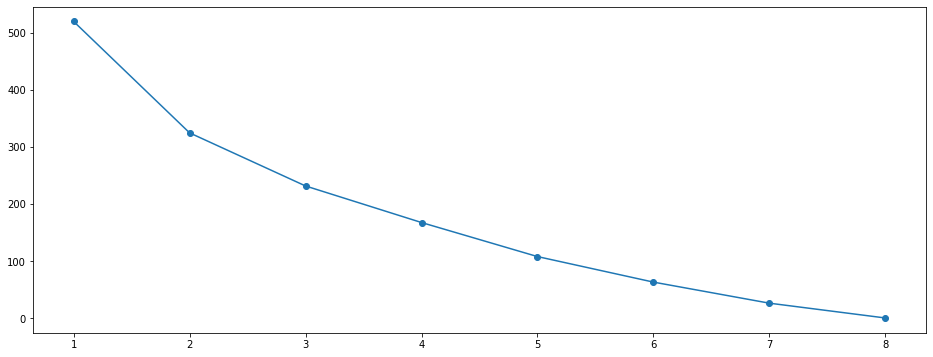

In [49]:
plt.figure(figsize=(16,6))
plt.plot( clusters_df.Num_Clusters, clusters_df.Cluster_Errors, marker = "o" );

In [50]:
clusters = KMeans(3)  # 3 clusters!
clusters.fit(X2)
clusters.cluster_centers_
clusters.labels_
X2['Crime_clusters'] = clusters.labels_
X2 = X2.sort_values(by=['Crime_clusters'],ascending = True)

def highlight_max(s):
    is_large = s.nlargest(1).values
    return ['background-color: yellow' if v in is_large else '' for v in s]

X2.style.apply(highlight_max)

,Total Crime (2012-2021),AREASQMI,TOTAL_POP,POP_DENSITY,POP_BLACK,POP_NATIVE_AMERICAN,POP_ASIAN,POP_HAWAIIAN,POP_OTHER_RACE,TWO_OR_MORE_RACES,NOT_HISPANIC_OR_LATINO,HISPANIC_OR_LATINO,POP_MALE,POP_FEMALE,AGE_0_5,AGE_5_9,AGE_10_14,AGE_15_17,AGE_18_19,AGE_20,AGE_21,AGE_22_24,AGE_25_29,AGE_30_34,AGE_35_39,AGE_40_44,AGE_45_49,AGE_50_54,AGE_55_59,AGE_60_61,AGE_65_66,AGE_67_69,AGE_70_74,AGE_75_79,AGE_80_84,AGE_85_PLUS,MEDIAN_AGE,TOTAL_HH,FAMILY_HH,PCT_FAMILY_HH,NONFAMILY_HH,PCT_NONFAMILY_HH,MALE_HH_NO_WIFE,FEMALE_HH_NO_HUSBAND,POP_25_PLUS_9TH_GRADE,POP_25_PLUS_GRADUATE,NO_DIPLOMA_25_PLUS,DIPLOMA_25_PLUS,NO_DEGREE_25_PLUS,ASSOC_DEGREE_25_PLUS,BACH_DEGREE_25_PLUS,UNEMPLOYMENT_RATE,PCT_BELOW_POV,PCT_BELOW_POV_FAM,PCT_BELOW_POV_WHITE,PCT_BELOW_POV_BLACK,PCT_BELOW_POV_NAT_AMER,PCT_BELOW_POV_ASIAN,PCT_BELOW_POV_OTHER,PCT_BELOW_POV_HISP,PCT_BELOW_POV_WHTE_NOHISP,PCT_BELOW_POV_TWO_RACES,MEDIAN_HH_INCOME,PER_CAPITA_INCOME,Business Establishments,Crime_clusters
0,44432,2.5359,82859,32674.4,25110,300,3509,111,6259,2596,65755,17104,41368,41491,4733,2644,1934,1223,2399,1613,1642,5487,15600,12286,7378,5099,4784,3963,2618,1420,802,1208,1778,954,505,738,31.3,34907,12253,35.1018,22654,64.8982,1634,3133,4324,22488,3224,6984,5293,1258,17613,6.6,13.5,11,7.7,23.3,8.7,6.9,26.8,17.9,7.7,11.5,82159,47982,141,0
3,28815,9.00194,83066,9227.56,46884,519,1755,31,9627,2287,66565,16501,40349,42717,5602,4421,4210,2467,1379,668,668,2893,7039,7149,5913,5760,6406,6003,5783,2078,1513,1859,2296,2063,1753,2407,39.3,30539,17699,57.9554,12840,42.0446,1591,5419,3927,15399,3920,11907,10500,2073,13032,9.9,11.9,8.7,5.2,14.6,6,10.3,14.9,14.4,5.2,11.3,74600,43880,204,0
5,51447,6.22105,84290,13549.2,29909,295,3573,40,1233,2529,79000,5290,40411,43879,4779,2747,2235,1088,1370,794,724,4596,13427,12512,8052,5474,4524,4350,4724,1830,1518,1596,2167,1522,816,958,33.9,40100,15110,37.6808,24990,62.3192,944,4157,1785,25882,3128,7079,6643,1852,19588,6.3,12.5,9.6,4.5,25.7,13.9,11.6,10.7,6.3,4.5,6.2,94343,58354,262,0
4,44646,10.3903,82049,7896.69,57733,335,1622,9,3758,1915,75058,6991,38692,43357,5778,3972,2654,2249,2817,1533,1531,3882,8514,7439,5996,5228,4828,4905,5274,1736,1108,1640,2361,2079,1947,2135,35.4,31656,14893,47.0464,16763,52.9536,1567,6726,2796,11168,5094,13788,11034,2196,11557,14.1,19,13.5,12.5,20.4,19.1,17.7,27.9,21.6,12.5,10.4,57554,32449,274,1
6,39060,8.80991,73290,8319.04,69005,219,225,17,1211,908,70987,2303,33916,39374,5230,4485,4333,2944,2162,1347,1107,3170,5036,5083,4154,5166,4794,5715,5272,1716,1254,1680,2370,1719,1290,1142,37,29266,15574,53.2153,13692,46.7847,1682,9499,2259,3309,6002,18683,10800,2569,4890,19.1,27.2,23.6,8.9,28,12.8,5.3,19.7,22.9,8.9,20,39165,22917,148,1
7,33096,11.9379,81133,6796.27,75259,110,310,12,711,872,79843,1290,35573,45560,7879,7061,5963,3596,2945,1800,1748,4070,6306,5951,4617,4873,4429,4978,5001,1578,1011,1211,1904,1026,634,432,29.3,29470,17747,60.2206,11723,39.7794,1886,11653,1858,2614,5958,18736,10975,2149,3781,22.9,37.7,35.3,10.8,38.8,54.1,21.6,51.2,36.3,10.8,36.4,30910,17596,178,1
1,57505,8.68452,77645,8940.62,6817,213,7640,30,2496,2875,69529,8116,39214,38431,2173,1110,571,486,6200,3363,3485,6463,12614,10475,6491,4175,3445,3413,3248,1447,1214,1325,1763,764,724,863,30.9,38870,9071,23.3368,29799,76.6632,458,754,1743,28509,988,2381,2980,940,16253,3.7,13.4,4.7,10.1,33.2,26,23.5,12.6,13.5,10.1,10.3,100388,72388,454,2
2,16701,10.9347,83152,7604.41,5730,163,5188,0,1864,3345,74944,8208,37151,46001,4259,4077,2814,1588,3526,1497,1499,3849,8672,7374,6069,5496,5025,5201,4388,1992,1574,2602,3343,2545,1349,1837,37,38582,16390,42.4809,22192,57.5191,740,1511,684,32503,740,2139,3808,1003,19166,3.7,9.4,1.9,7.6,21.7,0,13.2,27.1,13.7,7.6,9.8,112873,83452,112,2


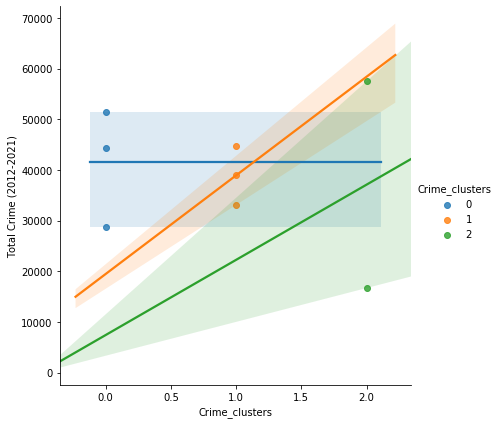

In [57]:
sns.lmplot('Crime_clusters' ,'Total Crime (2012-2021)', data=X2,
        hue = "Crime_clusters",
        fit_reg=True, size = 6 );

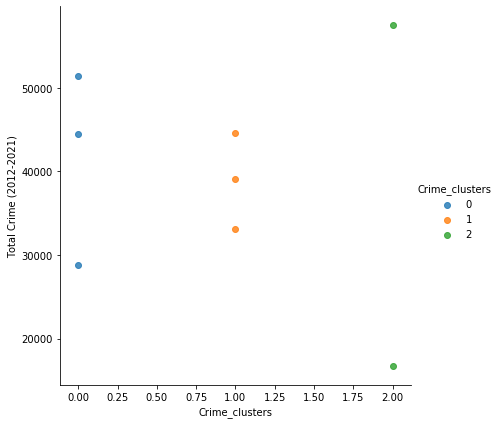

In [54]:
sns.lmplot('Crime_clusters' ,'Total Crime (2012-2021)', data=X2,
        hue = "Crime_clusters",
        fit_reg=False, size = 6 );

In [59]:
X = X2[['AREASQMI', 'TOTAL_POP', 'TOTAL_HH', 'UNEMPLOYMENT_RATE', 'PER_CAPITA_INCOME', 'PCT_BELOW_POV', 
        'Business Establishments']]
y = X2['Total Crime (2012-2021)']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Total Crime (2012-2021)   R-squared (uncentered):                   0.999
Model:                                 OLS   Adj. R-squared (uncentered):              0.992
Method:                      Least Squares   F-statistic:                              137.5
Date:                     Tue, 04 May 2021   Prob (F-statistic):                      0.0656
Time:                             20:32:17   Log-Likelihood:                         -68.901
No. Observations:                        8   AIC:                                      151.8
Df Residuals:                            1   BIC:                                      152.4
Df Model:                                7                                                  
Covariance Type:                 nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
AREASQMI                -2569.3582   1424.952     -1.803      0.322   -2.07e+04    1.55e+04
TOTAL_POP                  -0.3459      0.322     -1.074      0.477      -4.436       3.745
TOTAL_HH                    2.0189      1.169      1.728      0.334     -12.829      16.867
UNEMPLOYMENT_RATE        1616.2236   2001.695      0.807      0.568   -2.38e+04    2.71e+04
PER_CAPITA_INCOME          -0.2069      0.518     -0.400      0.758      -6.785       6.371
PCT_BELOW_POV            -456.3156    653.393     -0.698      0.612   -8758.467    7845.836
Business Establishments    95.0786     21.291      4.466      0.140    -175.448     365.605
==============================================================================
Omnibus:                        0.079   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.961   Jarque-Bera (JB):                0.285
Skew:                           0.133   Prob(JB):                        0.867
Kurtosis:                       2.115   Cond. No.                     1.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
#Auxillary 2
X = X2["Business Establishments"]
y = X2['Total Crime (2012-2021)']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Total Crime (2012-2021)   R-squared (uncentered):                   0.922
Model:                                 OLS   Adj. R-squared (uncentered):              0.910
Method:                      Least Squares   F-statistic:                              82.29
Date:                     Tue, 27 Apr 2021   Prob (F-statistic):                    4.05e-05
Time:                             21:42:54   Log-Likelihood:                         -86.198
No. Observations:                        8   AIC:                                      174.4
Df Residuals:                            7   BIC:                                      174.5
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Business Establishments   162.3261     17.895      9.071      0.000     120.012     204.640
==============================================================================
Omnibus:                        0.056   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.141
Skew:                          -0.062   Prob(JB):                        0.932
Kurtosis:                       2.360   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""